In [1]:
from IPython.display import clear_output

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, RMSprop



In [2]:
import os

save_dir = '/model/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Data Augmentation

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  
 

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)


results_dict = {}

Files already downloaded and verified


## Model 1 (main)

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1x1, out_channels3x3_reduce, out_channels3x3, out_channels5x5_reduce, out_channels5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1x1, kernel_size=1),
            nn.BatchNorm2d(out_channels1x1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels3x3_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels3x3_reduce, out_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels3x3),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels5x5_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels5x5_reduce, out_channels5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels5x5),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.BatchNorm2d(out_channels_pool),
            nn.ReLU()
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)

class Cifar10Classifier(nn.Module):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception2 = InceptionModule(64, 32, 32, 64, 8, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0)  
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.inception2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0) 
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Cifar10Classifier().to(device)
print(model)


Cifar10Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1

Accuracy: 0.8357
Precision: 0.8353
Recall: 0.8357
F1 Score: 0.8353
Confusion Matrix:
[[861   9  23  15  16   2   5   9  36  24]
 [  7 929   1   3   2   2   1   1   9  45]
 [ 50   1 755  30  71  33  37  18   5   0]
 [ 16   3  41 683  49 116  48  29   6   9]
 [  8   1  41  29 829  29  23  36   3   1]
 [  7   2  29 118  36 757  11  30   4   6]
 [  7   2  31  39  26  19 864   3   3   6]
 [  9   1  20  23  29  33   2 877   0   6]
 [ 40  16   8   8   5   3   0   3 896  21]
 [ 19  40   2   5   3   0   1   8  16 906]]


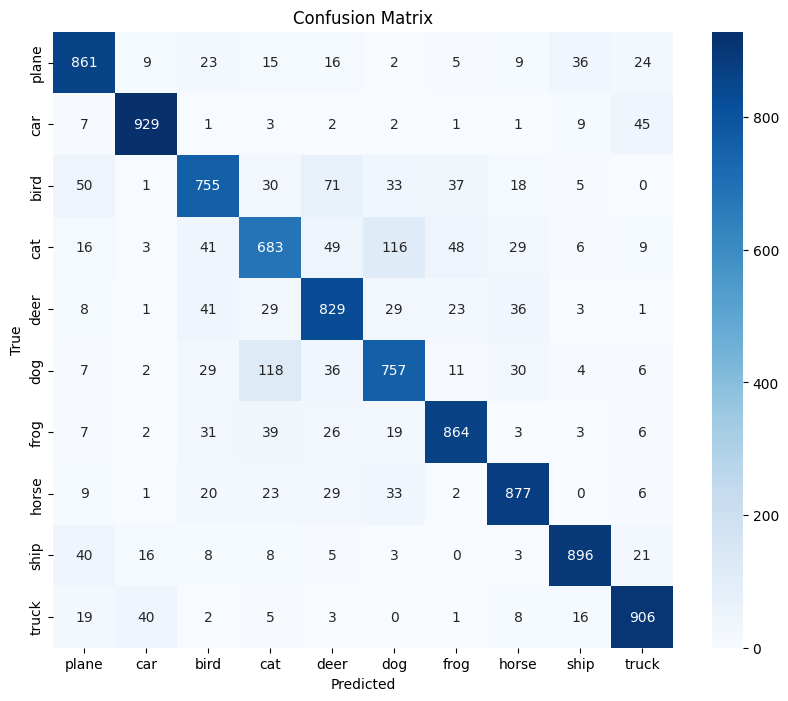

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model.load_state_dict(torch.load("/model/model_49.pth"))
model.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


results_dict["MainModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Model 2 

In [6]:
class Cifar10Classifier2(nn.Module):
    def __init__(self):
        super(Cifar10Classifier2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0)  
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Cifar10Classifier2().to(device)
print(model2)


Cifar10Classifier2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(

Accuracy: 0.8225
Precision: 0.8222
Recall: 0.8225
F1 Score: 0.8222
Confusion Matrix:
[[851   9  18  12  17   4   5   9  43  32]
 [ 13 911   1   3   2   0   2   0  16  52]
 [ 50   3 747  35  62  44  32  20   3   4]
 [ 19   4  55 656  48 130  38  27  12  11]
 [ 14   1  51  43 800  25  21  37   6   2]
 [  7   2  33 132  37 747  13  20   4   5]
 [  5   3  37  50  18  18 861   1   4   3]
 [  9   2  23  25  37  35   2 855   0  12]
 [ 47  19   7   6   1   1   1   2 897  19]
 [ 23  43   4   7   0   3   2   2  16 900]]


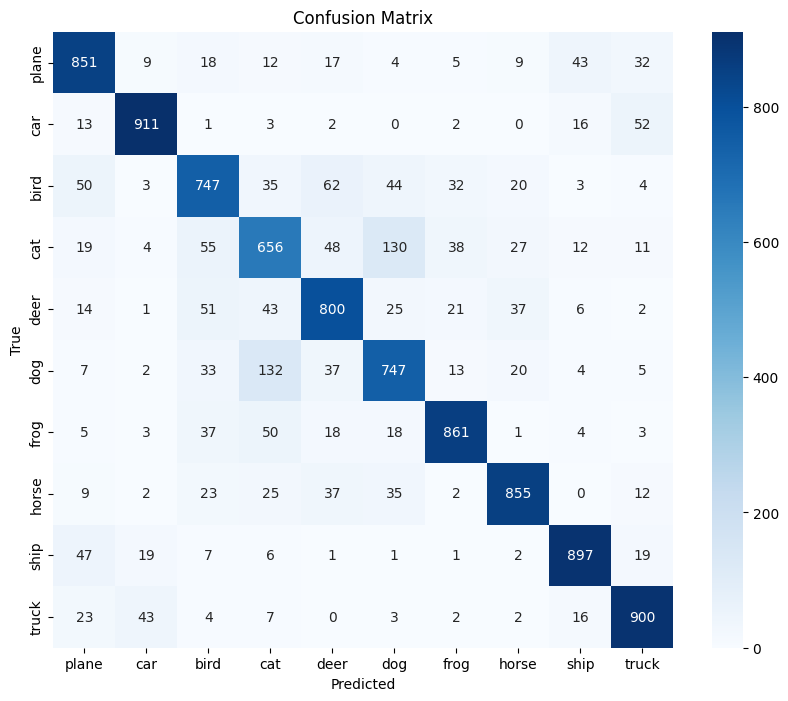

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model2.load_state_dict(torch.load("/model/model2_49.pth"))
model2.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model2(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["SecondModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Model 3 

In [8]:
class Cifar10Classifier3(nn.Module):
    def __init__(self):
        super(Cifar10Classifier3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0)  
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  # or x = x[0]

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Cifar10Classifier3().to(device)
print(model3)


Cifar10Classifier3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(

Accuracy: 0.8418
Precision: 0.8413
Recall: 0.8418
F1 Score: 0.8414
Confusion Matrix:
[[884   7  27   7  15   1   3   4  35  17]
 [  4 938   3   4   1   2   2   0   5  41]
 [ 46   0 778  36  62  30  30   6   6   6]
 [ 18   5  55 683  46 106  44  27   9   7]
 [ 12   1  46  34 812  26  27  34   5   3]
 [ 13   2  32 125  32 753  11  27   3   2]
 [  5   4  31  41  13  21 876   0   5   4]
 [ 10   2  14  27  30  28   1 885   0   3]
 [ 45  12   6  10   2   2   2   0 907  14]
 [ 16  43   5   7   2   0   2   6  17 902]]


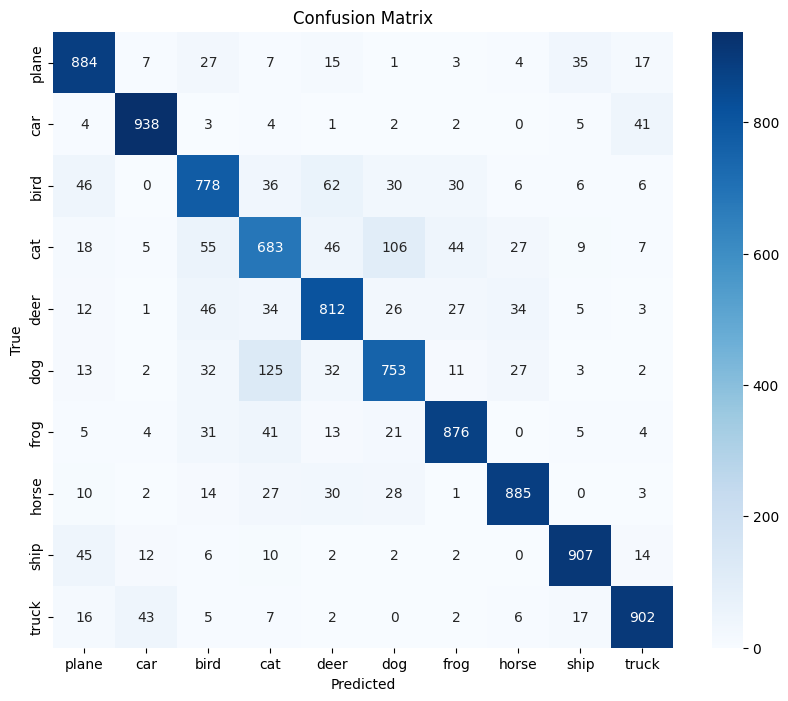

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model3.load_state_dict(torch.load("/model/model3_49.pth"))
model3.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model3(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["ThirdModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# First ensemble

Accuracy: 0.8560
Precision: 0.8558
Recall: 0.8560
F1 Score: 0.8558
Confusion Matrix:
[[884   7  27   7  15   1   3   4  35  17]
 [  4 938   3   4   1   2   2   0   5  41]
 [ 46   0 778  36  62  30  30   6   6   6]
 [ 18   5  55 683  46 106  44  27   9   7]
 [ 12   1  46  34 812  26  27  34   5   3]
 [ 13   2  32 125  32 753  11  27   3   2]
 [  5   4  31  41  13  21 876   0   5   4]
 [ 10   2  14  27  30  28   1 885   0   3]
 [ 45  12   6  10   2   2   2   0 907  14]
 [ 16  43   5   7   2   0   2   6  17 902]]


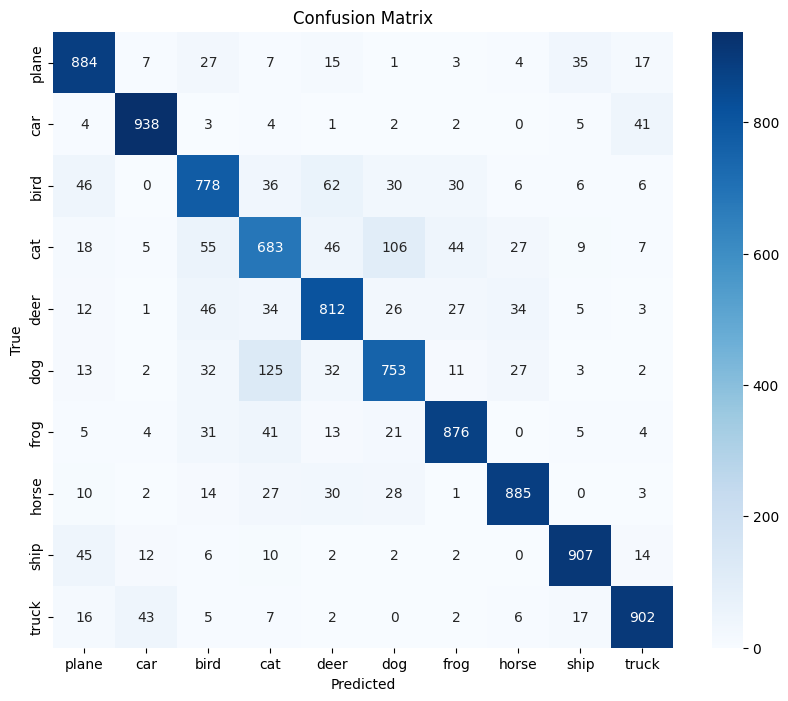

In [10]:
model.eval()
model2.eval()
model3.eval()

import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs1 = model(images)
        outputs2 = model2(images)
        outputs3 = model3(images)

        avg_outputs = (outputs1 + outputs2 + outputs3) / 3

        _, preds = torch.max(avg_outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["Ensemble"] = (accuracy, precision, recall, f1, conf_matrix) 



# AutoML (PyTorch Lightning)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
criterion = nn.CrossEntropyLoss()  
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1x1, out_channels3x3_reduce, out_channels3x3, out_channels5x5_reduce, out_channels5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1x1, kernel_size=1),
            nn.BatchNorm2d(out_channels1x1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels3x3_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels3x3_reduce, out_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels3x3),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels5x5_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels5x5_reduce, out_channels5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels5x5),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.BatchNorm2d(out_channels_pool),
            nn.ReLU()
        )

        self.out_channels = out_channels1x1 + out_channels3x3 + out_channels5x5 + out_channels_pool

        if in_channels != self.out_channels:
            self.residual = nn.Conv2d(in_channels, self.out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        inception_out = torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], 1)
        residual_out = self.residual(x)

        return F.relu(inception_out + residual_out)

class Cifar10Classifier( L.LightningModule):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception2 = InceptionModule(64, 32, 32, 64, 8, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0)  
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.inception2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  

        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)

        true_labels = labels.tolist()
        predicted_labels = preds.tolist()

        return true_labels, predicted_labels

    def on_test_epoch_end(self, outputs):
        all_true_labels = []
        all_predicted_labels = []

        for true_labels, predicted_labels in outputs:
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)
        return all_true_labels, all_predicted_labels
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Cifar10Classifier().to(device)
print(model4)


Cifar10Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model4.load_state_dict(torch.load("/model/model4_99.pth"))
model4.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model4(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

results_dict["AutoML"] = (accuracy, precision, recall, f1, conf_matrix) 


Accuracy: 0.8614
Precision: 0.8638
Recall: 0.8614
F1 Score: 0.8622
Confusion Matrix:
[[889   4  32  12   4   1   5   5  29  19]
 [  7 928   3   6   0   1   0   0   9  46]
 [ 28   1 839  41  35  28  14   9   2   3]
 [ 13   4  45 745  21 114  29  13  10   6]
 [  8   3  48  36 824  33  19  19   6   4]
 [  9   1  25 114  20 805   4  14   3   5]
 [  4   5  26  46  19  30 865   1   2   2]
 [  5   0  17  28  31  35   2 876   0   6]
 [ 33   5  11   7   2   2   4   0 920  16]
 [ 14  28   8  10   2   2   0   3  10 923]]


# Second ensemble

Accuracy: 0.8759
Precision: 0.8765
Recall: 0.8759
F1 Score: 0.8761
Confusion Matrix:
[[889   4  32  12   4   1   5   5  29  19]
 [  7 928   3   6   0   1   0   0   9  46]
 [ 28   1 839  41  35  28  14   9   2   3]
 [ 13   4  45 745  21 114  29  13  10   6]
 [  8   3  48  36 824  33  19  19   6   4]
 [  9   1  25 114  20 805   4  14   3   5]
 [  4   5  26  46  19  30 865   1   2   2]
 [  5   0  17  28  31  35   2 876   0   6]
 [ 33   5  11   7   2   2   4   0 920  16]
 [ 14  28   8  10   2   2   0   3  10 923]]


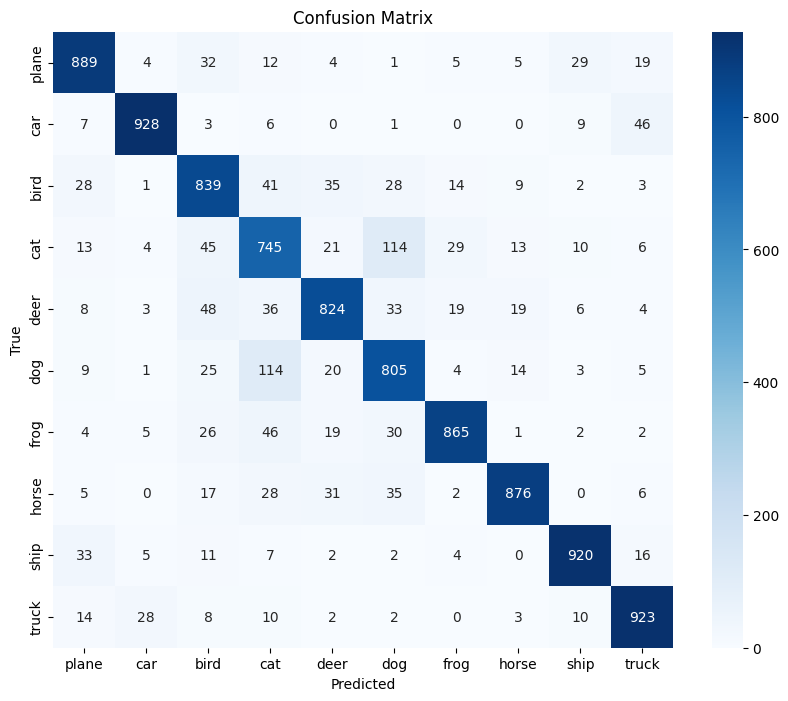

In [18]:
model.eval()
model2.eval()
model3.eval()
model4.eval()
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs1 = model(images)
        outputs2 = model2(images)
        outputs3 = model3(images)
        outputs4 = model4(images)
        avg_outputs = (outputs1 + outputs2 + outputs3 + outputs4) / 4

        _, preds = torch.max(avg_outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["Second_ensemble"] = (accuracy, precision, recall, f1, conf_matrix) 



# Fourth model - big one

In [53]:
class Inception(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Inception, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.out_channels = out_channels * 4

        if in_channels != self.out_channels:
            self.residual = nn.Conv2d(in_channels, self.out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        inception_out = torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], 1)
        residual_out = self.residual(x)

        return F.relu(inception_out + residual_out)
class Cifar10Classifier_extra(nn.Module):
    def __init__(self):
        super(Cifar10Classifier_extra, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = Inception(64, 64)
        self.inception2 = Inception(256, 128)
        self.inception3 = Inception(512, 256)
        self.inception4 = Inception(1024, 512)
        self.conv2 = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.conv2(x)
        x = F.adaptive_avg_pool2d(x, (4, 4))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model10 = Cifar10Classifier_extra().to(device)
model10.load_state_dict(torch.load("/model/model_extra2.pth"))


<All keys matched successfully>

Accuracy: 0.9156
Precision: 0.9155
Recall: 0.9156
F1 Score: 0.9155
Confusion Matrix:
[[933   5  13   2   4   0   4   3  24  12]
 [  5 954   0   1   1   2   0   0   4  33]
 [ 15   1 888  29  21  16  18   8   3   1]
 [  8   1  22 837  21  67  24  15   2   3]
 [  8   1  23  18 909  10  10  18   2   1]
 [  6   0  15  85  19 843   8  21   0   3]
 [  6   1  15  21   6   7 940   1   0   3]
 [  8   1   6  12  12   9   0 949   1   2]
 [ 20   5   2   4   0   0   1   1 959   8]
 [  6  31   3   3   1   0   1   1  10 944]]


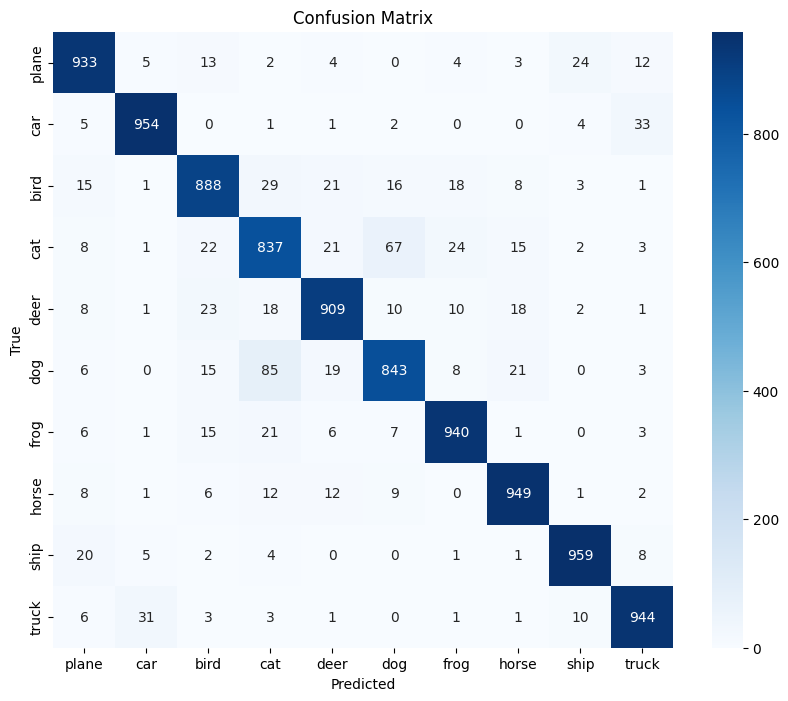

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model10.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model10(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["FourthModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Third ensamble

Accuracy: 0.9150
Precision: 0.9153
Recall: 0.9150
F1 Score: 0.9151
Confusion Matrix:
[[941   3  10   9   2   0   1   2  22  10]
 [  4 953   0   3   1   0   0   0   5  34]
 [ 18   0 903  29  17  15  12   3   3   0]
 [  9   2  26 837  17  72  20  12   2   3]
 [  3   1  25  20 904  14   9  19   3   2]
 [  5   0  18  89  22 848   3  11   1   3]
 [  5   2  16  24   6   8 935   1   1   2]
 [  9   0   9  14  19  14   1 931   1   2]
 [ 23   4   3   3   0   1   2   1 955   8]
 [  6  31   3   4   1   0   0   1  11 943]]


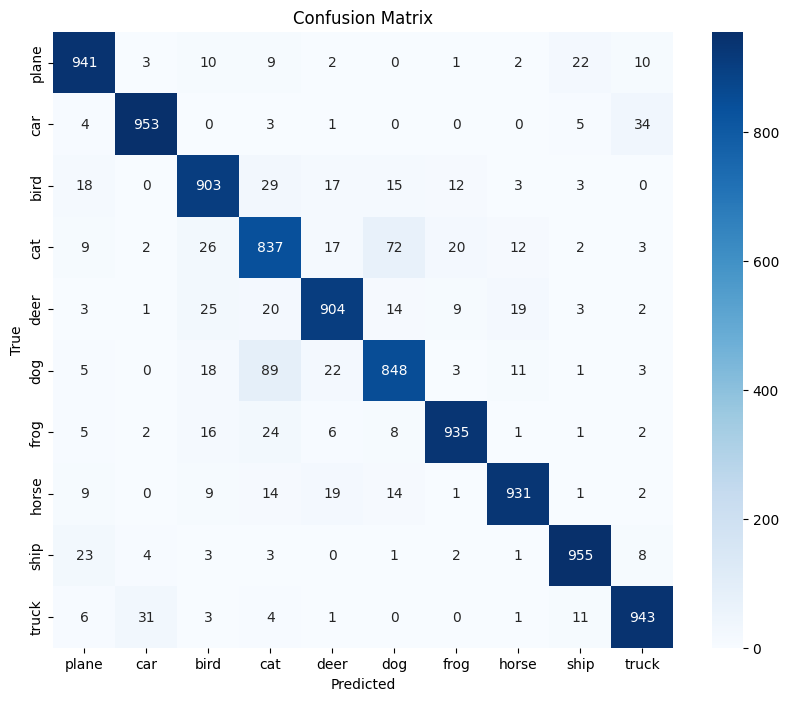

In [56]:
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs1 = model(images)
        outputs2 = model2(images)
        outputs3 = model3(images)
        outputs4 = model4(images)
        outputs5 = model10(images)
        avg_outputs = ( outputs4 + outputs5)/4
        _, preds = torch.max(avg_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["Third_ensemble"] = (accuracy, precision, recall, f1, conf_matrix) 

# Final results! 

### Main model

In [47]:
print(f'Accuracy: {results_dict["MainModel"][0]:.4f}')
print(f'Precision: {results_dict["MainModel"][1]:.4f}')
print(f'Recall: {results_dict["MainModel"][2]:.4f}')
print(f'F1 Score: {results_dict["MainModel"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["MainModel"][4]}')

Accuracy: 0.8357
Precision: 0.8353
Recall: 0.8357
F1 Score: 0.8353
Confusion Matrix:
[[861   9  23  15  16   2   5   9  36  24]
 [  7 929   1   3   2   2   1   1   9  45]
 [ 50   1 755  30  71  33  37  18   5   0]
 [ 16   3  41 683  49 116  48  29   6   9]
 [  8   1  41  29 829  29  23  36   3   1]
 [  7   2  29 118  36 757  11  30   4   6]
 [  7   2  31  39  26  19 864   3   3   6]
 [  9   1  20  23  29  33   2 877   0   6]
 [ 40  16   8   8   5   3   0   3 896  21]
 [ 19  40   2   5   3   0   1   8  16 906]]


### Second model

In [48]:
print(f'Accuracy: {results_dict["SecondModel"][0]:.4f}')
print(f'Precision: {results_dict["SecondModel"][1]:.4f}')
print(f'Recall: {results_dict["SecondModel"][2]:.4f}')
print(f'F1 Score: {results_dict["SecondModel"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["SecondModel"][4]}')

Accuracy: 0.8225
Precision: 0.8222
Recall: 0.8225
F1 Score: 0.8222
Confusion Matrix:
[[851   9  18  12  17   4   5   9  43  32]
 [ 13 911   1   3   2   0   2   0  16  52]
 [ 50   3 747  35  62  44  32  20   3   4]
 [ 19   4  55 656  48 130  38  27  12  11]
 [ 14   1  51  43 800  25  21  37   6   2]
 [  7   2  33 132  37 747  13  20   4   5]
 [  5   3  37  50  18  18 861   1   4   3]
 [  9   2  23  25  37  35   2 855   0  12]
 [ 47  19   7   6   1   1   1   2 897  19]
 [ 23  43   4   7   0   3   2   2  16 900]]


### Third model

In [49]:
print(f'Accuracy: {results_dict["ThirdModel"][0]:.4f}')
print(f'Precision: {results_dict["ThirdModel"][1]:.4f}')
print(f'Recall: {results_dict["ThirdModel"][2]:.4f}')
print(f'F1 Score: {results_dict["ThirdModel"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["ThirdModel"][4]}')

Accuracy: 0.8418
Precision: 0.8413
Recall: 0.8418
F1 Score: 0.8414
Confusion Matrix:
[[884   7  27   7  15   1   3   4  35  17]
 [  4 938   3   4   1   2   2   0   5  41]
 [ 46   0 778  36  62  30  30   6   6   6]
 [ 18   5  55 683  46 106  44  27   9   7]
 [ 12   1  46  34 812  26  27  34   5   3]
 [ 13   2  32 125  32 753  11  27   3   2]
 [  5   4  31  41  13  21 876   0   5   4]
 [ 10   2  14  27  30  28   1 885   0   3]
 [ 45  12   6  10   2   2   2   0 907  14]
 [ 16  43   5   7   2   0   2   6  17 902]]


### Auto ML

In [50]:
print(f'Accuracy: {results_dict["AutoML"][0]:.4f}')
print(f'Precision: {results_dict["AutoML"][1]:.4f}')
print(f'Recall: {results_dict["AutoML"][2]:.4f}')
print(f'F1 Score: {results_dict["AutoML"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["AutoML"][4]}')

Accuracy: 0.8614
Precision: 0.8638
Recall: 0.8614
F1 Score: 0.8622
Confusion Matrix:
[[889   4  32  12   4   1   5   5  29  19]
 [  7 928   3   6   0   1   0   0   9  46]
 [ 28   1 839  41  35  28  14   9   2   3]
 [ 13   4  45 745  21 114  29  13  10   6]
 [  8   3  48  36 824  33  19  19   6   4]
 [  9   1  25 114  20 805   4  14   3   5]
 [  4   5  26  46  19  30 865   1   2   2]
 [  5   0  17  28  31  35   2 876   0   6]
 [ 33   5  11   7   2   2   4   0 920  16]
 [ 14  28   8  10   2   2   0   3  10 923]]


# Fourth model

In [58]:
print(f'Accuracy: {results_dict["FourthModel"][0]:.4f}')
print(f'Precision: {results_dict["FourthModel"][1]:.4f}')
print(f'Recall: {results_dict["FourthModel"][2]:.4f}')
print(f'F1 Score: {results_dict["FourthModel"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["FourthModel"][4]}')

Accuracy: 0.9156
Precision: 0.9155
Recall: 0.9156
F1 Score: 0.9155
Confusion Matrix:
[[933   5  13   2   4   0   4   3  24  12]
 [  5 954   0   1   1   2   0   0   4  33]
 [ 15   1 888  29  21  16  18   8   3   1]
 [  8   1  22 837  21  67  24  15   2   3]
 [  8   1  23  18 909  10  10  18   2   1]
 [  6   0  15  85  19 843   8  21   0   3]
 [  6   1  15  21   6   7 940   1   0   3]
 [  8   1   6  12  12   9   0 949   1   2]
 [ 20   5   2   4   0   0   1   1 959   8]
 [  6  31   3   3   1   0   1   1  10 944]]


### Ensemble learning

In [77]:
print(f'Accuracy: {results_dict["Ensemble"][0]:.4f}')
print(f'Precision: {results_dict["Ensemble"][1]:.4f}')
print(f'Recall: {results_dict["Ensemble"][2]:.4f}')
print(f'F1 Score: {results_dict["Ensemble"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["Ensemble"][4]}')

Accuracy: 0.8456
Precision: 0.8449
Recall: 0.8456
F1 Score: 0.8451
Confusion Matrix:
[[863  14  25  19   8   1   3   8  32  27]
 [ 11 925   2   4   1   1   2   0  12  42]
 [ 54   1 718  27  79  40  46  25   2   8]
 [ 19   5  59 660  54 113  44  24  13   9]
 [ 13   2  35  38 822  21  26  35   5   3]
 [  8   1  37 133  26 740  13  32   2   8]
 [  5   6  28  44  20  13 871   4   2   7]
 [  8   1  21  25  32  30   4 869   1   9]
 [ 36  19   3  11   2   5   3   2 908  11]
 [ 18  45   4   4   0   1   1   7  15 905]]


# Second ensemble learning

In [83]:
print(f'Accuracy: {results_dict["Second_ensemble"][0]:.4f}')
print(f'Precision: {results_dict["Second_ensemble"][1]:.4f}')
print(f'Recall: {results_dict["Second_ensemble"][2]:.4f}')
print(f'F1 Score: {results_dict["Second_ensemble"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["Second_ensemble"][4]}')

Accuracy: 0.8700
Precision: 0.8703
Recall: 0.8700
F1 Score: 0.8699
Confusion Matrix:
[[912   5  12  20  10   3   2   8  21   7]
 [  6 927   1   0   2   0   1   0   9  54]
 [ 38   1 803  43  56  27  12  14   6   0]
 [ 14   2  46 732  57  89  29  19   8   4]
 [ 11   0  38  30 868  15  12  21   3   2]
 [  4   1  35 116  29 784   5  22   1   3]
 [  6   4  39  46  21  16 859   1   6   2]
 [  7   1  19  20  30  22   1 896   1   3]
 [ 42   9   5   4   3   4   2   6 909  16]
 [ 15  30   7   8   3   0   3   4  11 919]]


# Third ensemble learning 

In [59]:
print(f'Accuracy: {results_dict["Third_ensemble"][0]:.4f}')
print(f'Precision: {results_dict["Third_ensemble"][1]:.4f}')
print(f'Recall: {results_dict["Third_ensemble"][2]:.4f}')
print(f'F1 Score: {results_dict["Third_ensemble"][3]:.4f}')
print(f'Confusion Matrix:\n{results_dict["Third_ensemble"][4]}')

Accuracy: 0.9150
Precision: 0.9153
Recall: 0.9150
F1 Score: 0.9151
Confusion Matrix:
[[941   3  10   9   2   0   1   2  22  10]
 [  4 953   0   3   1   0   0   0   5  34]
 [ 18   0 903  29  17  15  12   3   3   0]
 [  9   2  26 837  17  72  20  12   2   3]
 [  3   1  25  20 904  14   9  19   3   2]
 [  5   0  18  89  22 848   3  11   1   3]
 [  5   2  16  24   6   8 935   1   1   2]
 [  9   0   9  14  19  14   1 931   1   2]
 [ 23   4   3   3   0   1   2   1 955   8]
 [  6  31   3   4   1   0   0   1  11 943]]


# Final the best model - Model fourth 

Accuracy: 0.9156


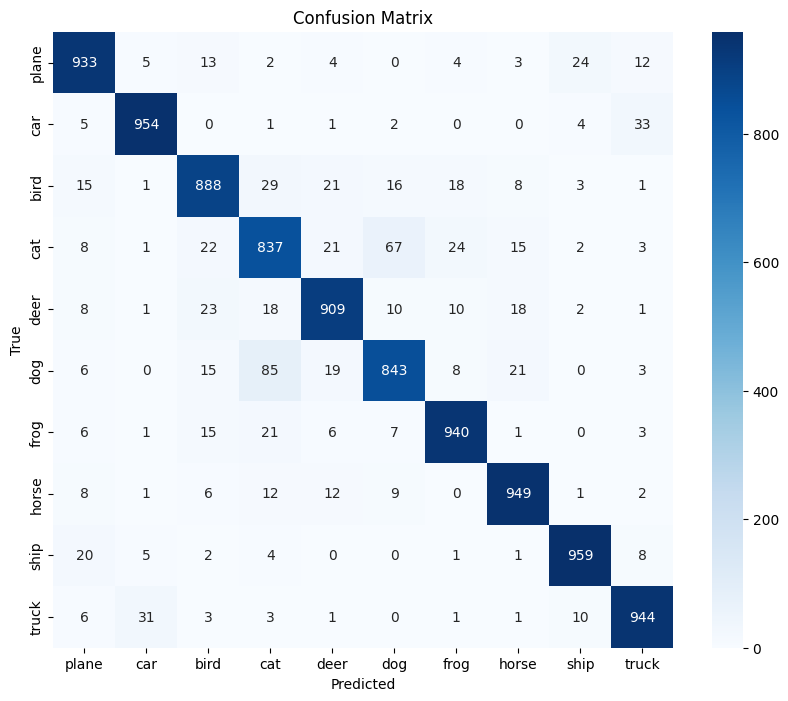

In [60]:
print(f'Accuracy: {results_dict["FourthModel"][0]:.4f}')
plt.figure(figsize=(10, 8))
sns.heatmap(results_dict["FourthModel"][4], annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The complex model outperformed others models. 

Combing it with other models decreased its accuracy than increase it. It is probably because it is significantly better than other model around 4% to 8% accuracy score.

This like other models struggling mainly with cats and dogs. I wanted to create special model only for distinguishing between cats and dogs but I did not manage to do it on time.